In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib
from matplotlib.colors import ListedColormap
import os
import sys
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize

In [34]:
L = 0.0005
q = 1.5
N_ASSETS = 5
exp_idx = 0

# X mixer params
Dirr_X = "./experiments_approx_Q2"
enable_X = 1
p_X = [5, 7, 9]
boost_X = 5000
color_X = {
    5: "#ffcc99",
    7: "#ff6600",
    9: "#cc0000"
}

# Preserving Mixer params
# Dirr_P = "./experiments_approx_Q2"
Dirr_P = "./experiments_approx_Q2"
enable_P = 1
p_P = [5]
boost_P = 10500
init_bases = [12]
is_GA_P = [False]
color_P = {
    5: "#5ae95a",
    7: "#0f920f",
    9: "#014901"
}



In [35]:
points_optim = [] # (risk, ret, "mode", layer, is_GA)
P, ret, cov, budget, qubit = None, None, None, None, None
name_idx = f"A{N_ASSETS}_E{exp_idx}"

eps_min_X, eps_max_X = 1e9, -1e9
if enable_X == 1:
    for p in p_X:
        dirr_X = f"{Dirr_X}/exp_p{p}_L{L}_q{q}_torch"
        report_file_X = f"report_X_boost_{boost_X}.csv"
        expect_file_X = f"expectation_X_boost_{boost_X}.npz"
        df_X = pd.read_csv(f"{dirr_X}/{report_file_X}")
        data_X = np.load(f"{dirr_X}/{expect_file_X}")
        
        if P is None:
            P = data_X[f"{name_idx}_P"]
            ret = data_X[f"{name_idx}_ret"]
            cov = data_X[f"{name_idx}_cov"]
            budget = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Budget'].values[0]
            qubit = P.shape[0] * 2
            
        risk = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Risk'].values[0] / q
        ret_final = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Return'].values[0]
        violation = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Budget_Violations'].values[0]
        violation = np.sqrt(violation / L)
        eps_min_X, eps_max_X = min(eps_min_X, violation), max(eps_max_X, violation)
        points_optim.append((risk, ret_final, "X", p, False, violation))

eps_min_P, eps_max_P = 1e9, -1e9
if enable_P == 1:
    for bases in init_bases:
        mode_name = f"Preserving{bases}"
        for is_GA in is_GA_P:
            GA_postfix = "_GA" if is_GA else ""
            for p in p_P:
                dirr_P = f"{Dirr_P}/exp_p{p}_L1_q{q}_torch"
                report_file_P = f"report_{mode_name}_boost_{boost_P}{GA_postfix}.csv"
                expect_file_P = f"expectation_{mode_name}_boost_{boost_P}{GA_postfix}.npz"
                df_P = pd.read_csv(f"{dirr_P}/{report_file_P}")
                data_P = np.load(f"{dirr_P}/{expect_file_P}")

                if P is None:
                    P = data_P[f"{name_idx}_P"]
                    ret = data_P[f"{name_idx}_ret"]
                    cov = data_P[f"{name_idx}_cov"]
                    budget = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Budget'].values[0]
                
                risk = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Risk'].values[0] / q
                ret_final = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Return'].values[0]
                violation = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Budget_Violations'].values[0]
                violation = np.sqrt(violation / 1)
                eps_min_P, eps_max_P = min(eps_min_P, violation), max(eps_max_P, violation)
                points_optim.append((risk, ret_final, mode_name, p, is_GA, violation))

P_b = P / budget
ret_b = ret * P_b
cov_b = np.diag(P_b) @ cov @ np.diag(P_b)

P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(budget, P, ret, cov)

ll = np.zeros((qubit, 1<<qubit), dtype=np.float32)
a_0 = np.zeros(1<<qubit, dtype=np.float32)
a_1 = np.ones(1<<qubit, dtype=np.float32)
idxx = np.arange(1<<qubit, dtype=np.int32)
for i in range(qubit):
    ll[i] = np.where(idxx%(1<<(qubit-i))<(1<<(qubit-i-1)), a_0,  a_1)
ll = np.ascontiguousarray(ll.T)

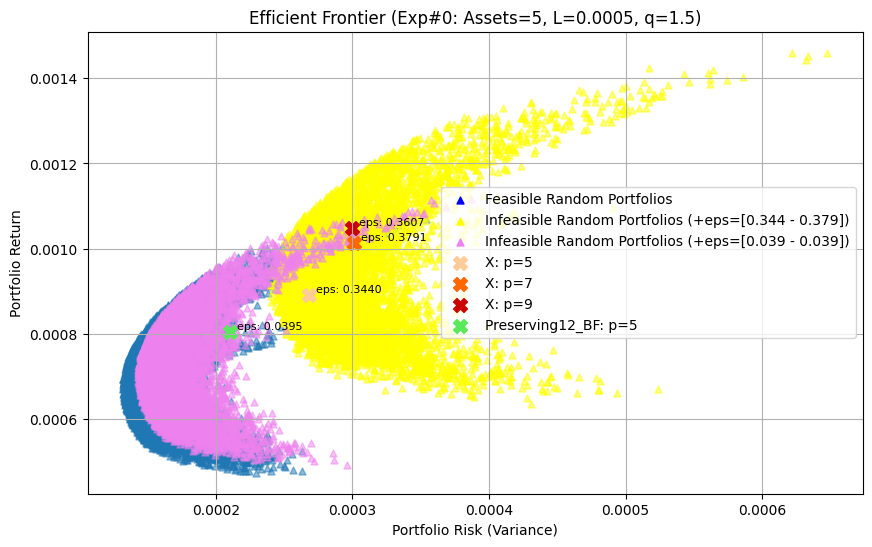

In [36]:
enable_feasible = 1
ret_list, cov_list = [],[]
if enable_feasible:
    for i in range(15000):
        x = np.random.dirichlet(np.ones(len(P)))
        n = (x * budget) / P
        # n = n.astype(np.int32)

        ret_list.append(ret_b.T @ n)
        cov_list.append(n.T @ cov_b @ n)

enable_infeasible_X = 1
out_budget_min_X, out_budget_max_X = eps_min_X, eps_max_X
ret_list_out_X, cov_list_out_X = [],[]
if enable_infeasible_X:
    for i in range(7500):
        x = np.random.dirichlet(np.ones(len(P)))
        out_budget = np.random.uniform(out_budget_min_X, out_budget_max_X)
        n = (x * budget * (1+out_budget)) / P
        # n = n.astype(np.int32)
        ret_list_out_X.append(ret_b.T @ n)
        cov_list_out_X.append(n.T @ cov_b @ n)

enable_infeasible_P = 1
out_budget_min_P, out_budget_max_P = eps_min_P, eps_max_P
ret_list_out_P, cov_list_out_P = [],[]
if enable_infeasible_P:
    for i in range(7500):
        x = np.random.dirichlet(np.ones(len(P)))
        out_budget = np.random.uniform(out_budget_min_P, out_budget_max_P)
        # out_budget = 0.059
        n = (x * budget * (1+out_budget)) / P
        # n = n.astype(np.int32)
        ret_list_out_P.append(ret_b.T @ n)
        cov_list_out_P.append(n.T @ cov_b @ n)

enable_int_feasible = 0
hsv = matplotlib.colormaps['hsv']
red_pos, green_pos = 0.0, 0.35
hsv_cut = ListedColormap([hsv(green_pos + (red_pos - green_pos) * (v)) for v in np.linspace(0, 1, 256)])
ret_list_int, cov_list_int, col_list_int = [], [], []
if enable_int_feasible:
    # now_cov = (ll.reshape(-1, 1, qubit) @ cov_b.reshape(1, qubit, qubit) @ ll.reshape(-1, qubit, 1)).flatten()
    ret_list_int_ = np.einsum('ij,j->i', ll, ret_bb)
    cov_list_int_ = np.einsum('ij,jk,ik->i', ll, cov_bb, ll)
    P_now = np.einsum('ij,j->i', ll, P_bb)
    P_now = np.abs(P_now - 1)
    P_l = []
    for i in range(len(P_now)):
        if P_now[i] <= 0.45:
            P_l.append(P_now[i])
            ret_list_int.append(ret_list_int_[i])
            cov_list_int.append(cov_list_int_[i])
    P_now = np.array(P_l)
    print(P_now.min(), P_now.max())
    norm_pos = (P_now - np.min(P_now)) / (np.max(P_now) - np.min(P_now))
    col_list_int = [hsv_cut(v) for v in norm_pos]
    # col_list_int = [hsv(red_pos + (green_pos - red_pos) * (1 - v)) for v in norm_pos]
    

ret_list, cov_list = np.array(ret_list), np.array(cov_list)
ret_list_out_X, cov_list_out_X = np.array(ret_list_out_X), np.array(cov_list_out_X)
ret_list_out_P, cov_list_out_P = np.array(ret_list_out_P), np.array(cov_list_out_P)
ret_list_int, cov_list_int, col_list_int = np.array(ret_list_int), np.array(cov_list_int), np.array(col_list_int)

# P: green, X: red

plt.figure(figsize=(10,6))
# Triangle

if enable_feasible:
    plt.scatter(cov_list, ret_list, s=25, alpha=0.5, marker='^', label=None)
    plt.scatter([], [], s=25, alpha=1.0, color='blue', marker='^', label='Feasible Random Portfolios')

if enable_infeasible_X:
    plt.scatter(cov_list_out_X, ret_list_out_X, s=25, alpha=0.5, color='yellow', marker='^', label=None)
    plt.scatter([], [], s=25, alpha=1.0, color='yellow', marker='^', label=f'Infeasible Random Portfolios (+eps=[{out_budget_min_X:.3f} - {out_budget_max_X:.3f}])')

if enable_infeasible_P:
    plt.scatter(cov_list_out_P, ret_list_out_P, s=25, alpha=0.5, color='violet', marker='^', label=None)
    plt.scatter([], [], s=25, alpha=1.0, color='violet', marker='^', label=f'Infeasible Random Portfolios (+eps=[{out_budget_min_P:.3f} - {out_budget_max_P:.3f}])')
    
if enable_int_feasible:
    plt.scatter(cov_list_int, ret_list_int, s=25, alpha=0.5, color=col_list_int, marker='o', label=None)
    # plt.scatter([], [], s=25, alpha=1.0, color='gray', marker='o', label='Feasible Integer Portfolios')
    # right color label bar show gradient
    sm = plt.cm.ScalarMappable(cmap=hsv_cut, norm=plt.Normalize(vmin=P_now.min(), vmax=P_now.max()))
    plt.colorbar(sm, ax=plt.gca(), label='Portfolio eps')

# plt.scatter(risk_final, ret_final, color='red', s=100, label='Optimized Portfolio', marker='X')
# plt.colorbar(label='Portfolio Price')
for point in points_optim:
    risk, ret_final, mode, layer, is_GA, violation = point
    color_map = color_P if mode.startswith("Preserving") else color_X
    color = color_map[layer]
    marker = 'X' if is_GA else 'X'
    plt.scatter(risk, ret_final, color=color, s=100, label=f'{mode}{("_GA" if is_GA else "_BF") if mode != "X" else ""}: p={layer}', marker=marker)
    # text annotation for violation
    plt.text(risk, ret_final, f'  eps: {violation:.4f}', verticalalignment='bottom', horizontalalignment='left', fontsize=8)
plt.legend()
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Portfolio Return')
plt.title(f'Efficient Frontier (Exp#{exp_idx}: Assets={N_ASSETS}, L={L}, q={q})')
plt.grid(True)
plt.show()

In [25]:
assert False

AssertionError: 

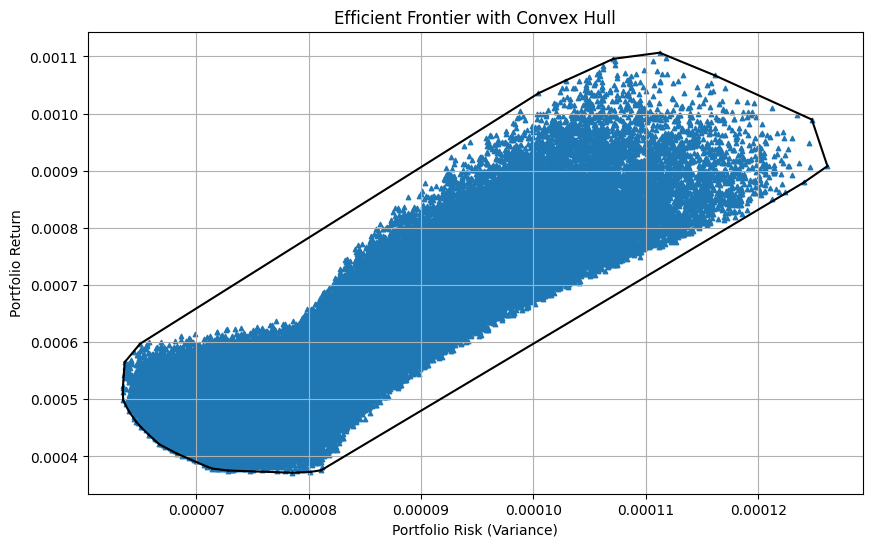

In [ ]:
# convex hull
from scipy.spatial import ConvexHull
points = np.array(list(zip(cov_list, ret_list)))
hull = ConvexHull(points)
plt.figure(figsize=(10,6))
plt.scatter(points[:,0], points[:,1], s=10, label='Random Portfolios', marker='^')

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier with Convex Hull')
plt.grid(True)
plt.show()

In [ ]:
def find_portfolio_for_risk(mu, cov, target_variance, is_upper_bound=True, options={}):
    n_assets = len(mu)
    def objective_function(weights):
        return (mu.T @ weights) * (-1 if is_upper_bound else 1)
    
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: weights.T @ cov @ weights - target_variance}
    )
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_weights = np.ones(n_assets) / n_assets
    # initial_weights = np.random.rand(n_assets)

    result = minimize(
        fun=objective_function,
        x0=initial_weights,
        method='COBYLA',
        bounds=bounds,
        constraints=constraints,
        options=options
    )

    return result

def find_bound_var_portfolio(cov, is_min=True):
    n_assets = len(cov)
    def objective(weights):
        return (weights.T @ cov @ weights) * (1 if is_min else -1)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_weights = np.random.rand(n_assets)

    result = minimize(objective, initial_weights, method='COBYLA', bounds=bounds, constraints=constraints, options={'maxiter': 10000, 'disp': 0})
    gmv_weights = result.x
    gmv_return = gmv_weights.T @ ret
    gmv_variance = gmv_weights.T @ cov @ gmv_weights
    return gmv_return, gmv_variance

In [ ]:
min_var_return, min_var_value  = find_bound_var_portfolio(cov, is_min=True)
max_var_return, max_var_value = find_bound_var_portfolio(cov, is_min=False)

print(f"Minimum Variance Portfolio: Return = {min_var_return:.6f}, Variance = {min_var_value:.6f}")
print(f"Maximum Variance Portfolio: Return = {max_var_return:.6f}, Variance = {max_var_value:.6f}")

Minimum Variance Portfolio: Return = 0.000676, Variance = 0.000132
Maximum Variance Portfolio: Return = 0.001135, Variance = 0.000422


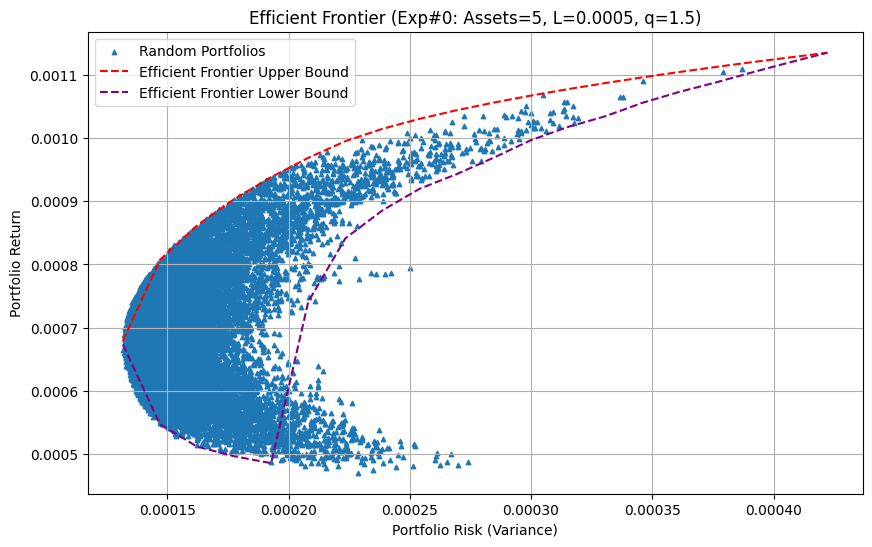

In [ ]:
risk_intervals = np.linspace(min_var_value, max_var_value, 20)
# print(risk_intervals)
efficient_frontier_upper, efficient_frontier_lower = [], []
cou = 0
for target_risk in risk_intervals:
    cou += 1
    # optimal_portfolio_upper = find_portfolio_for_risk(ret, cov, target_risk, True, options=({'disp': 1} if cou in [3, 4, 5] else {}))
    optimal_portfolio_upper = find_portfolio_for_risk(ret, cov, target_risk, True)
    optimal_portfolio_lower = find_portfolio_for_risk(ret, cov, target_risk, False)
    if optimal_portfolio_upper.success:
        portfolio_return_upper = -optimal_portfolio_upper.fun
        efficient_frontier_upper.append((target_risk, portfolio_return_upper))
    if optimal_portfolio_lower.success:
        portfolio_return_lower = optimal_portfolio_lower.fun
        efficient_frontier_lower.append((target_risk, portfolio_return_lower))
    # else:
        # print(f"Optimization failed for target risk: {target_risk}") 

plt.figure(figsize=(10,6))
plt.scatter(points[:,0], points[:,1], s=10, label='Random Portfolios', marker='^')

# for point in points_optim:
#     risk, ret_final, mode, layer, is_GA = point
#     color_map = color_P if mode.startswith("Preserving") else color_X
#     color = color_map[layer]
#     marker = 'X' if is_GA else 'X'
#     plt.scatter(risk, ret_final, color=color, s=100, label=f'{mode}{("_GA" if is_GA else "_BF") if mode != "X" else ""}: p={layer}', marker=marker)

efficient_frontier_upper = np.array(efficient_frontier_upper)
efficient_frontier_lower = np.array(efficient_frontier_lower)
plt.plot(efficient_frontier_upper[:,0], efficient_frontier_upper[:,1], 'r--', label='Efficient Frontier Upper Bound')
plt.plot(efficient_frontier_lower[:,0], efficient_frontier_lower[:,1], '--', color='purple', label='Efficient Frontier Lower Bound')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Portfolio Return')
plt.title(f'Efficient Frontier (Exp#{exp_idx}: Assets={N_ASSETS}, L={L}, q={q})')
plt.grid(True)
plt.legend()
plt.show()

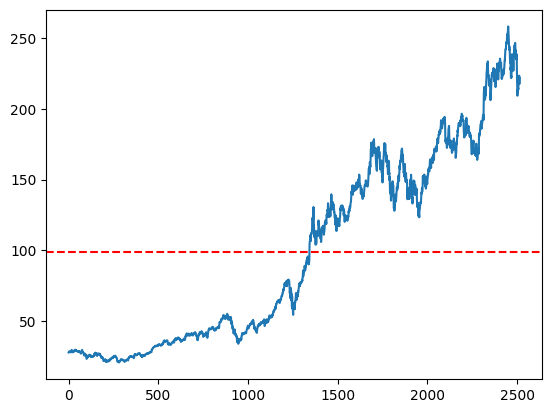

In [ ]:
data_ret_p_pd = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_with_returns.csv")
# print(data_ret_p_pd.tail())
# select only 2015 - 2025
AAPL_price = data_ret_p_pd[(data_ret_p_pd['Ticker'] == 'AAPL') & (data_ret_p_pd['Date'] >= '2015-04-01') & (data_ret_p_pd['Date'] <= '2025-04-01')]['Close'].values
plt.plot(AAPL_price)
plt.axhline(y=np.mean(AAPL_price), color='r', linestyle='--', label='Mean Price')